<a href="https://colab.research.google.com/github/ICSM/pgmuvi/blob/main/pgmuvi_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use pgmuvi - a brief introduction



`pgmuvi` is a package to infer the multiwavelength behaviour of astronomical lightcurves using Gaussian Processes. It uses the `torch` and `gpytorch` libraries to define GP models, and the probabilistic programming language `pyro` to perform optimisation and sampling of the parameter space.

## Why pgmuvi

Many packages exist to interpret lightcurves with GPs, so why do we need another one? `pgmuvi` builds on the latest highly-optimised libraries which allow inference with arbitrary GP kernels. This makes it feasible to implement models that are very general, which is important in astronomy where lightcurves can have a wide range of different properties. However, this normally results in a speed penalty, since naive GPs scale with $\mathcal{O}\left(n^3\right)$; to combat this, the libraries implement scalable approaches to GP inference, such as GPU computing. This allows both a wide range of GP kernels and fast inference, meaning that `pgmuvi` can be applied to arbitrary astronomical lightcurves without taking _that much_ longer than codes which are restricted to special cases but blisteringly fast in those cases.

## What does pgmuvi do

The objective is to understand what the PSD of the variability is, and in the case of (quasi-)periodic variables determine their dominant periods. To do this, `pgmuvi` uses a `SpectralMixtureKernel`, which models the PSD of the covariances of the GP as a Gaussian Mixture model. This is a very flexible model which is able to represent a wide range of different kinds of behaviour, so can be useful for a wide range of astronomical lightcurves.

## How to use pgmuvi

The rest of this notebook is basically a quickstart guide to `pgmuvi`. It generates sythetic observations, but you can replace these with reading in your own data and passing it to `pgmuvi`'s `Lightcurve` classes to apply it to your own data.

In [1]:
!pip install git+https://github.com/ICSM/pgmuvi.git
try: #This won't work right now - instead clone the repository and `pip install -e .`
    import pgmuvi
except ImportError:
    !pip install pgmuvi
    import pgmuvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ICSM/pgmuvi.git to /tmp/pip-req-build-yyil09ko
  Running command git clone --filter=blob:none --quiet https://github.com/ICSM/pgmuvi.git /tmp/pip-req-build-yyil09ko
  Resolved https://github.com/ICSM/pgmuvi.git to commit aeba1ea40eed3695fba2c0cad84ca202bd3aee35
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 20.6 MB/s eta 0:00:00
  Created wheel for pgmuvi: filename=pgmuvi-0.0.1-py3-none-any.whl size=28016 sha256=5778350602fa58d8a53f06687c9f3ee3a451d60953a47878168cc05fc053614b
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9_tazvr/wheels/e5/e1/42/1783219abbb6b91e6c8eb8543e56c839cea246850950842794
Successfully built pgmuvi


Now we have imported/installed pgmuvi, we can use it to fit some data. For the purposes of this tutorial, we will generate two synthetic datasets - a single-wavelength lightcurve with very simple behaviour, and a second multi-wavelength one with some more complex patterns in it. It is important to note that the data must be in the form of `torch` tensors, rather than numpy arrays or other data types.

In [2]:
import torch
import numpy as np
""" Let's generate some synthetic data from a perturbed sine curve
    but on the same time sampling as the real data"""

P = np.random.uniform(30, 300)#137. #Days!
print("True period: ",P," days")
n_data = 400
jd_min = 2450000
n_periods = np.random.uniform(3,10)
jd_max = jd_min + P*(n_periods)
print("Simulating for ",n_periods," periods")

#train_mag =
#train_mag = train_mag + 0.1*torch.randn_like(train_mag)
#train_mag_err = 0.1*train_mag

period_guess = P*(np.random.uniform()+0.5)#147 #this number is in the same units as our original input.

#generate data from a simple case - superimpose two sine curves and add noise
timestamps_1d = torch.Tensor(np.random.uniform(jd_min, jd_max, size=n_data))#generate random x data here
fluxes_1d = torch.sin(timestamps_1d*(2*np.pi/P))#generate random y data here
fluxes_1d += 0.1*torch.randn_like(fluxes_1d)
flux_err_1d = 0.1*fluxes_1d


#now generate some data from a more complex case, maybe drawing from a specific PSD to test if pgmuvi reconstructs it
#timestamps_2d = #generate random x data here
#wavelengths_2d = #generate random x data here
#fluxes_2d = #generate random y data here
#flux_err_2d =
P0, P1 = 1000, 220
n_data1 = n_data
n_data2 = n_data // 2
timestamps1_2d = torch.Tensor(np.random.uniform(jd_min, jd_max, size=n_data1))
timestamps2_2d = torch.Tensor(np.random.uniform(jd_min, jd_max, size=n_data2))
timestamps_2d = torch.concat((timestamps1_2d, timestamps2_2d), dim=0)

bands1_2d = torch.Tensor(np.array([0.854] * n_data1))
bands2_2d = torch.Tensor(np.array([2.206] * n_data2))
bands_2d = torch.concat((bands1_2d, bands2_2d), dim=0)

flux1_2d = torch.Tensor(np.sin(timestamps1_2d * (2 * np.pi / P0)))
flux1_2d += 0.1*torch.randn_like(flux1_2d)
flux1_err_2d = 0.1*flux1_2d

flux2_2d = torch.Tensor(np.sin(timestamps2_2d * (2 * np.pi / P1) + 0.255 * jd_min))
flux2_2d += 0.18*torch.randn_like(flux2_2d)
flux2_err_2d = 0.02*flux2_2d

fluxes_2d = torch.concat((flux1_2d, flux2_2d), dim=0)
flux_err_2d = torch.concat((flux1_err_2d, flux2_err_2d), dim=0)

print(timestamps_2d.shape, bands_2d.shape, fluxes_2d.shape, flux_err_2d.shape)

timestamps_bands_2d = torch.stack((timestamps_2d, bands_2d), 0).T
timestamps_bands_2d.shape

True period:  115.36595358991647  days
Simulating for  3.6772399895337906  periods
torch.Size([600]) torch.Size([600]) torch.Size([600]) torch.Size([600])


torch.Size([600, 2])

Now that we've got some simple data, we can feed it to pgmuvi and see how it handles it.

In [46]:
from pgmuvi.lightcurve import Lightcurve

lightcurve_1d = Lightcurve(timestamps_1d, fluxes_1d, yerr = flux_err_1d, xtransform='minmax')

In [49]:
fit_1d = lightcurve_1d.fit(model='1D', likelihood='learn')
fit_1d['covar_module.raw_mixture_means'][-1].shape

/usr/local/lib/python3.10/dist-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Parameter name: likelihood.second_noise_covar.raw_noise    value = tensor([0.])
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_mixture_weights           value = tensor([-1.6111, -1.6111, -1.6111, -1.6111])
Parameter name: covar_module.raw_mixture_means             value = tensor([[[114.4584]],

        [[119.0611]],

        [[197.4130]],

        [[206.9362]]])
Parameter name: covar_module.raw_mixture_scales            value = tensor([[[-0.3542]],

        [[ 4.6394]],

        [[ 2.6371]],

        [[ 0.7922]]])


100%|██████████| 300/300 [00:11<00:00, 26.38it/s]


(4, 1, 1)

In [3]:
from pgmuvi.lightcurve import Lightcurve

lightcurve_2d = Lightcurve(timestamps_bands_2d, fluxes_2d, yerr=flux_err_2d, xtransform='minmax')

In [5]:
lightcurve_2d._xdata_transformed

tensor([[0.3952, 0.0000],
        [0.6577, 0.0000],
        [0.0494, 0.0000],
        ...,
        [0.8957, 1.0000],
        [0.4325, 1.0000],
        [0.0376, 1.0000]])

The `xtransform` argument is important. The computing time and numerical stability of this GP model depends somewhat on the range of frequencies it is asked to compute the PSD on, so it is common to transform the inputs to some simple interval that ensures the frequencies are easier. Astronomical timeseries often cover very long times, and therefore very low frequencies if left in their original units (e.g. Julian Dates), which are particularly difficult to compute on. By default, `Lightcurve` therefore transforms the data so that it is in the closed interval $\left[0, 1\right]$, although other transformations (or none) can be defined by the user.

Now that we have a lightcurve, we can try to fit it:

In [5]:
lightcurve_1d.fit(model='1D', likelihood='learn')

/usr/local/lib/python3.10/dist-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Parameter name: likelihood.second_noise_covar.raw_noise    value = tensor([0.])
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_mixture_weights           value = tensor([-1.6579, -1.6579, -1.6579, -1.6579])
Parameter name: covar_module.raw_mixture_means             value = tensor([[[127.1717]],

        [[391.8958]],

        [[651.7497]],

        [[162.1297]]])
Parameter name: covar_module.raw_mixture_scales            value = tensor([[[  0.5632]],

        [[  3.4423]],

        [[  0.9186]],

        [[152.7348]]])


100%|██████████| 300/300 [00:12<00:00, 24.84it/s]


{'loss': [array(1.1897311, dtype=float32),
  array(1.1616926, dtype=float32),
  array(1.1430725, dtype=float32),
  array(1.1262151, dtype=float32),
  array(1.106982, dtype=float32),
  array(1.0896527, dtype=float32),
  array(1.0779651, dtype=float32),
  array(1.0703101, dtype=float32),
  array(1.0631976, dtype=float32),
  array(1.0566541, dtype=float32),
  array(1.0512356, dtype=float32),
  array(1.0470397, dtype=float32),
  array(1.0420771, dtype=float32),
  array(1.0353714, dtype=float32),
  array(1.0277749, dtype=float32),
  array(1.0199382, dtype=float32),
  array(1.0129901, dtype=float32),
  array(1.0053471, dtype=float32),
  array(0.99590945, dtype=float32),
  array(0.9857301, dtype=float32),
  array(0.97562224, dtype=float32),
  array(0.9657413, dtype=float32),
  array(0.9566052, dtype=float32),
  array(0.9482417, dtype=float32),
  array(0.9401237, dtype=float32),
  array(0.93226624, dtype=float32),
  array(0.9249599, dtype=float32),
  array(0.9180829, dtype=float32),
  array(0.

In [4]:
fit_2d = lightcurve_2d.fit(model='2D', likelihood='learn')

/usr/local/lib/python3.10/dist-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Parameter name: likelihood.second_noise_covar.raw_noise    value = tensor([0.])
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_mixture_weights           value = tensor([-1.8318, -1.8318, -1.8318, -1.8318])
Parameter name: covar_module.raw_mixture_means             value = tensor([[[ 1.0646e+01, -2.4273e+00]],

        [[ 5.9574e+02, -5.2209e-01]],

        [[ 8.0280e+02, -7.6714e-01]],

        [[ 5.5933e+01, -2.0602e+00]]])
Parameter name: covar_module.raw_mixture_scales            value = tensor([[[11.1874, -0.5954]],

        [[ 0.5851,  1.7152]],

        [[ 8.6113,  6.3122]],

        [[-0.7521, -0.0140]]])


100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


In [8]:
fit_2d['covar_module.raw_mixture_means'][-1][...,1]

array([[-0.3819104 ],
       [-2.297274  ],
       [-2.05949   ],
       [-0.42606166]], dtype=float32)

In [5]:
lightcurve_2d.print_results()
# fit_2d['covar_module.raw_mixture_means'][-1].shape


loss: [-0.1682667]
delta_loss: [-0.00013813]
likelihood.second_noise_covar.raw_noise: [-4.017097]
mean_module.raw_constant: [0.36060512]
covar_module.raw_mixture_weights: [-0.17250215 -9.035862   -6.768217   -6.5249863 ]
covar_module.raw_mixture_means: [  0.83416253 441.12158    600.6385      54.89423   ]
covar_module.raw_mixture_means: [-0.8982118 -0.3867209 -0.5682279 -0.9573706]
covar_module.raw_mixture_scales: [-0.13667259 -1.913095    9.651292   -3.8698494 ]
covar_module.raw_mixture_scales: [0.4237135 1.2704645 4.675483  0.6021402]


this is a very simple case, and we have not specified any of the extra keywords that `fit` exposes. You will probably want to specify an initial guess of the GP hyperparameters, and the default number of components in the mixture model for the PSD is 4. Each mixture has a mean, scale and weight for the Gaussian, and there is a mean function (a constant mean) and an extra free parameter to learn additional noise in the input data.

Now that the fit is completed, you can manually inspect the results

In [6]:
lightcurve_1d.results

{'loss': [array(1.1897311, dtype=float32),
  array(1.1616926, dtype=float32),
  array(1.1430725, dtype=float32),
  array(1.1262151, dtype=float32),
  array(1.106982, dtype=float32),
  array(1.0896527, dtype=float32),
  array(1.0779651, dtype=float32),
  array(1.0703101, dtype=float32),
  array(1.0631976, dtype=float32),
  array(1.0566541, dtype=float32),
  array(1.0512356, dtype=float32),
  array(1.0470397, dtype=float32),
  array(1.0420771, dtype=float32),
  array(1.0353714, dtype=float32),
  array(1.0277749, dtype=float32),
  array(1.0199382, dtype=float32),
  array(1.0129901, dtype=float32),
  array(1.0053471, dtype=float32),
  array(0.99590945, dtype=float32),
  array(0.9857301, dtype=float32),
  array(0.97562224, dtype=float32),
  array(0.9657413, dtype=float32),
  array(0.9566052, dtype=float32),
  array(0.9482417, dtype=float32),
  array(0.9401237, dtype=float32),
  array(0.93226624, dtype=float32),
  array(0.9249599, dtype=float32),
  array(0.9180829, dtype=float32),
  array(0.

but this output is quite ugly. Instead, you can call some routines to make informative summaries of them that are easier to read

In [7]:
lightcurve_1d.print_results()

loss: [0.61919093]
delta_loss: [-0.00084525]
likelihood.second_noise_covar.raw_noise: [-4.968051]
mean_module.raw_constant: [0.06334872]
covar_module.raw_mixture_weights: [-7.8535476 -7.7382183 -8.925081  -0.8231659]
covar_module.raw_mixture_means: [ 97.6911  290.93378 483.96454  84.9315 ]
covar_module.raw_mixture_scales: [-1.885784  -0.4796805 -2.1882071 80.97089  ]


and you can also generate some plots of the output; for example the lightcurve with the fit results on top of it

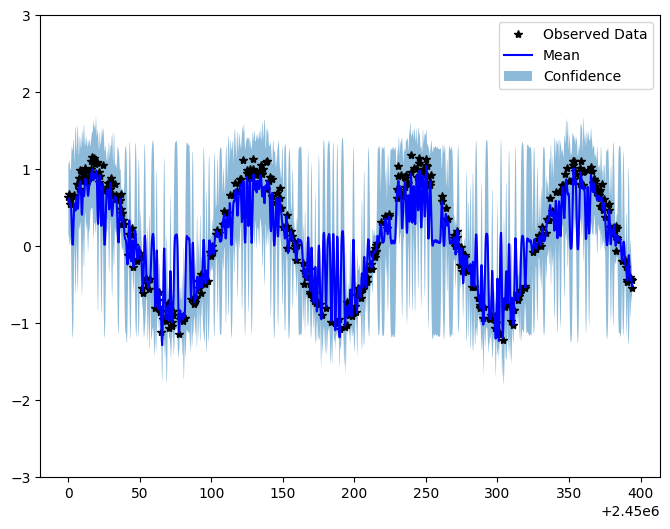

In [8]:
lightcurve_1d.plot()

or the maximum a-posteriori PSD that pgmuvi has inferred

In [9]:
lightcurve_1d.plot_psd()

TypeError: ignored

If you want more information, you can use MCMC to sample the posterior of the model (this is still being developed!)

In [10]:
lightcurve_1d.mcmc()

AttributeError: ignored

This takes a while, unless you run it using a GPU - if that works. That's a subject for a different tutorial. Now we've got some results from MCMC, we should take a look at them. First, we can look at the trace

In [11]:
#internally, Lightcurve should call arviz and produce these outputs
lightcurve_1d.summary()
lightcurve_1d.plot_trace()
lightcurve_1d.pairplot()

AttributeError: ignored

Now if you plot the lightcurve and results, you can get samples drawn from the MCMC chains instead of the mean and credible interval of the MAP solution

In [12]:
lightcurve_1d.plot(mcmc_samples = True)

TypeError: ignored

and you can do the same thing with the PSD

In [ ]:
lightcurve_1d.plot_psd(mcmc_samples = True)